<a href="https://colab.research.google.com/github/KobbeEriksson/Rice-Image-Classification-Project/blob/main/rice_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project for Image Classification
# Jacob Eriksson

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


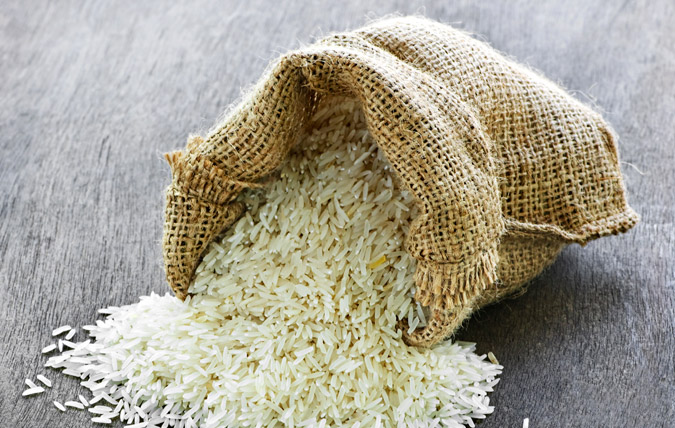

In [ ]:
from IPython.display import Image
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')
Image(filename='ris.jpg')

<l>In this notebook I'll attempt to create a convolutional neural network that can classify 5 different categories of rice images.
<br> and also showcase my understanding of deep neural networks and transfer learning.

<br> I'll breakdown the notebook according to the project tasks which is:

<l> 1. Dataset Selection
<br> 2. Data Preprocessing
<br> 3. Building a CNN Model
<br> 4. Transfer Learning
<br> 5. Model Evaluation

<l> So with those tasks in mind, let's get underway.

### 1. Dataset Selection

<l> The selected dataset is from kaggle: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

<l> This dataset contains 75 000 images of rice plants with 15 000 images for each of the 5 categories.
<br> These categories are: Arborio, Basmati, Ipsala, Jasmine and Karacadag.
<br> Each image is 250x250 and has a black background with an individual rice grain in the center.

<l> The dataset should be sufficiently large and while individual rice grains are not the most complex nor necessarily diverse they still have some variation in shape and color.
<br> I'll show some image examples that should showcase the variation.

<l> And so I believe that the dataset should be sufficient for a challenging problem but also still be able to create a model that can generalize well.

### Importing the necessary libraries and modules for the project.

In [ ]:
import os
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Dropout, MaxPooling2D, Activation
import warnings
import zipfile
import timeit
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings(action='once')

device_name = tf.test.gpu_device_name()

### Loading the dataset from our local directory.

<l> The dataset is in a zip file and so we'll need to unzip it and then load it into our notebook.
<br> By having it in an if-statement we don't need to unzip it every time we run the notebook.


In [ ]:

# Define the dataset folder path
dataset_folder_name = 'Rice_Image_Dataset'
folder_path = '/content/drive/MyDrive/Colab Notebooks/'

# Check if the folder exists
if not os.path.exists(dataset_folder_name):
    try:
        # Define the path to the ZIP file
        zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Rice_Dataset.zip'

        # Unzip the dataset
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)

        print('Dataset successfully unzipped.')

    except Exception as e:
        print(f'Error: {str(e)}')
else:
    print('Dataset folder already exists.')



Dataset folder already exists.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<l> We create empty lists for the images and labels and then loop through the folders and images to append them to the lists.
<br> And with that we have our dataset loaded into our notebook. and we can move on to the next task.

In [ ]:
data_dir = './Rice_Image_Dataset'

# List categories, excluding hidden folders (e.g., .ipynb_checkpoints)
categories = [category for category in os.listdir(data_dir) if not category.startswith('.')]
print(categories)

X, Y = [], []

for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        X.append(img_path)
        Y.append(category)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


### 2. Data Preprocessing

<l> Now let's create our training and testing sets.

<l> We'll do a 70/15/15 split for training, validation and testing respectively, although we might tweak this later if necessary.
<br> Let's also print out the shape of the sets to make sure that they are correct.

In [ ]:
# Dividing Training to 70%, Validation to 15% and Testing to 15%

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print('Total data size: ', len(X))
print('Training data size: ', len(x_train))
print('Validation data size: ', len(x_val))
print('Testing data size: ', len(x_test))

Total data size:  75000
Training data size:  52500
Validation data size:  11250
Testing data size:  11250


<l> Seems like the sets are being created correctly.

<l> We'll now place our sets into dataframes to make it easier to work with them.

In [ ]:
train_df = pd.DataFrame({'FileName': x_train, 'Category': y_train})
test_df = pd.DataFrame({'FileName': x_test, 'Category': y_test})
val_df = pd.DataFrame({'FileName': x_val, 'Category': y_val})

<l> Ok, now let's do some data augmentation, resizing/normalization.

<l> We're gonna use ImageDataGenerator to augment our data.

<l> Our training set is normalized by resizing it with 1./255 to ensure that the values are between 0 and 1.
<br> This helps keep our model weights more uniformly updated, which hopefully will lead to faster convergence and better generalization.

<l> We use shear_range to shear the image by an maximum angle of 0.2 radians in a random direction.
<br> This is to help the model generalize better by making the images more diverse.

<l> We then use zoom_range to zoom the image by a random factor of 0.2 in a random direction.
<br> This is also to help the model generalize better by making the images more diverse.

<l> Our test and validation sets are only resized by 1./255, since we want to keep them as close to the original as possible.

In [ ]:
height, width = 64, 64 # Image height and width
batchSize = 10
numClasses = len(categories) # Number of classes (outputs)
epochsNum = 2 # Number of epochs

# Creating data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2, zoom_range=0.2,
                                  horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating iterators (tuples of (x, y))
train = train_datagen.flow_from_dataframe(train_df, x_col='FileName', y_col='Category',
                                         target_size=(height, width),
                                         batch_size=batchSize, class_mode='categorical')
test = test_datagen.flow_from_dataframe(test_df, x_col='FileName', y_col='Category',
                                         target_size=(height, width),
                                         batch_size=batchSize, class_mode='categorical')
validation = test_datagen.flow_from_dataframe(val_df, x_col='FileName', y_col='Category',
                                         target_size=(height, width),
                                         batch_size=batchSize, class_mode='categorical')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


### So far, so good, let's look at some images from our training set.
### This way we also get a visual to see if everything seems to be working as intended.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


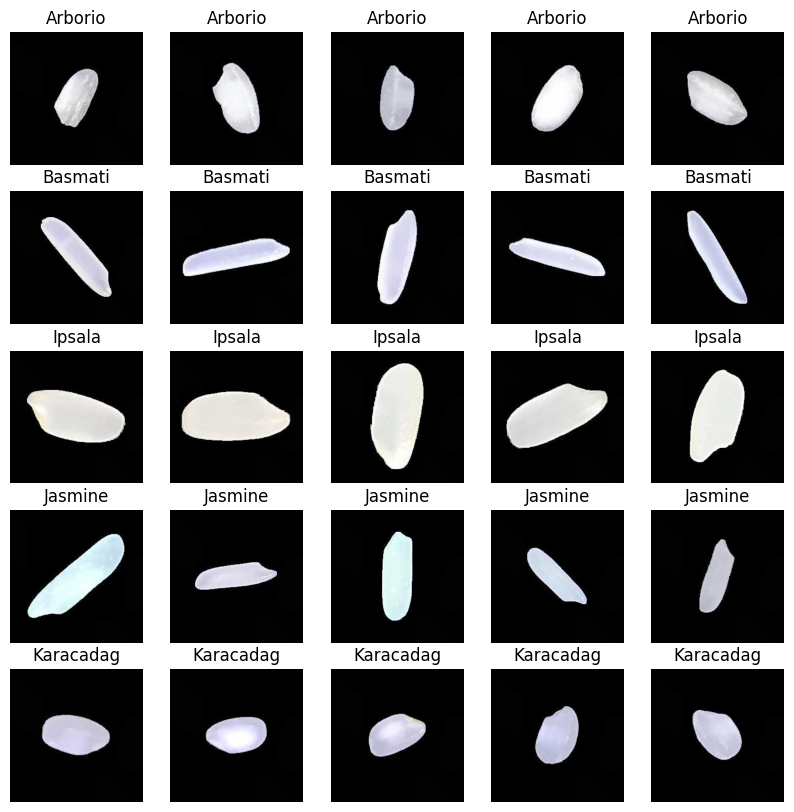

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        img = plt.imread(train_df[train_df['Category'] == categories[i]][
                         'FileName'].values[j])
        ax[i, j].imshow(img)
        ax[i, j].set_title(categories[i])
        ax[i, j].axis('off')
plt.show()

### Seems good, the images seem to in their correct categories.
<l> And from a quick glance they seem different enough to at least be able to distinguish them from each other.

<l> Let's make a pie figure to see the distribution of the categories in our sets aswell.

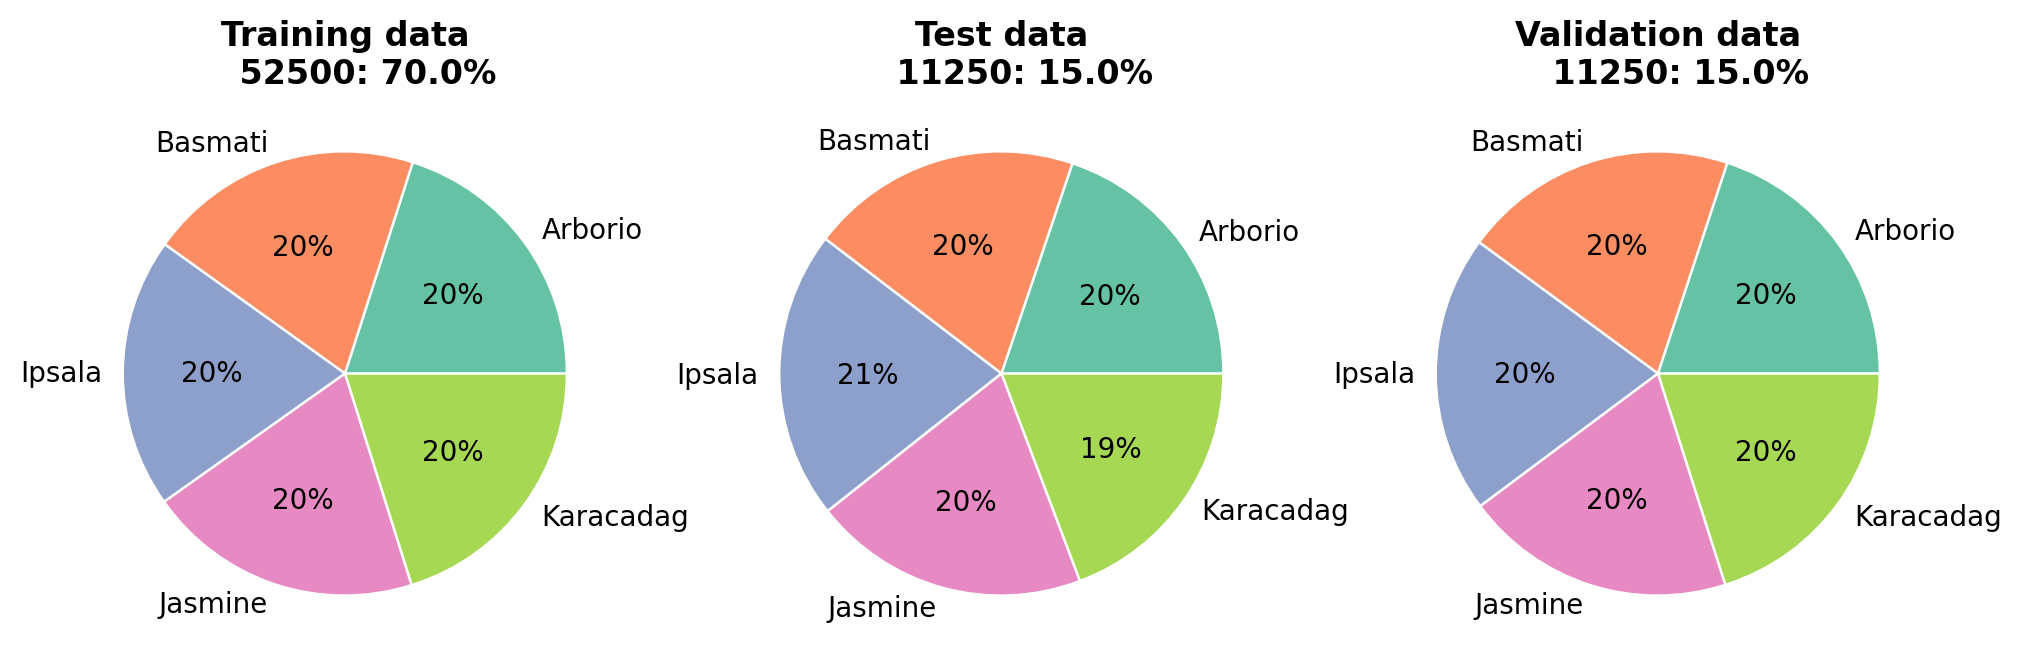

In [ ]:
j = 0
pieTitles = ['Training', 'Test', 'Validation']
dataFrames = [train_df, test_df, val_df]
plt.figure(figsize=[12, 8], dpi=200)

for i in [train, test, validation]:
    plt.subplot(1, 3, j+1)
    frequency = np.unique(i.classes, return_counts=True)
    plt.pie(frequency[1], labels = categories, explode=(0.01, 0.01, 0.01, 0.01, 0.01),
            autopct='%1.0f%%', colors=sns.color_palette('Set2'))
    plt.axis('off')
    # title text:
    text = f'''{pieTitles[j]} data
    {len(dataFrames[j])}: {round(len(dataFrames[j])/(len(dataFrames[0])+len(dataFrames[1])+len(dataFrames[2]))*100, 2)}%'''

    plt.title(text, fontweight='bold')
    j+=1

plt.show()

### Seems like the distribution is pretty even, although Isapala in test set has 21% while Karacadag has 19%.

<l> This seems odd, since the amount of images should be able to divide evenly into 5 categories between the sets.
<br> This might have something to do with the randomization of the sets, so we'll keep it in mind in case we get problems.
<br> Although it shouldn't be a problem since the distribution is still pretty even.

### 3. Building a CNN Model

<l> Now we'll build our CNN model.

<l> We'll start with a very simple model and then add more layers and tweak the parameters to see if we can improve the model as we go along.

<l> With a class it should simplify the process in the future as we want to create new models or add layers on top of an existing model.

In [ ]:
class SimpleCNN:
    def __init__(self, input_shape):
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

    def add_conv_layer(self, filters, kernel_size=(3, 3), activation='relu'):
        self.model.add(Conv2D(filters, kernel_size=kernel_size, activation=activation))

    def add_maxpool_layer(self, pool_size=(2, 2)):
        self.model.add(MaxPooling2D(pool_size=pool_size))

    def add_flatten_layer(self):
        self.model.add(Flatten())

    def add_dense_layer(self, units, activation='relu'):
        self.model.add(Dense(units, activation=activation))

    def add_dropout_layer(self, rate):
        self.model.add(Dropout(rate))

    def add_batchnorm_layer(self):
        self.model.add(BatchNormalization())

    def add_conv_block(self, filters, kernel_size=(3, 3), activation='relu'):
        self.model.add(Conv2D(filters, kernel_size=kernel_size, activation=activation))
        self.model.add(BatchNormalization())
        self.model.add(Activation(activation))

    def add_dense_block(self, units, activation='relu'):
        self.model.add(Dense(units, activation=activation))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))

    def learn_rate_schedule(self, epoch):
        if epoch < 10:
            return 0.001
        elif epoch < 20:
            return 0.0001
        else:
            return 0.00001

    def l2_regularizer(self, rate=0.01):
        return keras.regularizers.l2(rate)

    def grid_search(self, params, train_generator, validation_generator, epochs=10):
        with ThreadPoolExecutor(max_workers=10) as executor:
            for param in params:
                executor.submit(self.model.fit, train, validation=validation_generator, epochs=epochs)

    def summary(self):
        self.model.summary()

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit_model(self, train_generator, validation_generator, epochs=10):
        history = self.model.fit(
        train,
        epochs=epochs,
        validation_data=validation
        )
        return history

    def build(self):
        return self.model

<l> Using our new class we'll make a not too complicated model, even with google colab the process is quite slow so that's why we only have a batch size of 10 and 2 epochs in total to make the model creation not take 5 hours.

<l> Now this can lead to different issues like underfitting, slow convergence and more noise/poor generalization. But hopefully I'm showing that if you wanted to optimize it's only relatively few tweaks in the code which may/may not lead to better generalization.

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(height, width, 3)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(numClasses, activation='softmax'))

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn.fit(train, epochs=epochsNum, validation_data=validation)


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:2610: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  ndimage.interpolation.affine_transform(


Epoch 1/2
1052/5250 [=====>........................] - ETA: 3:53:26 - loss: 0.5047 - accuracy: 0.7850

KeyboardInterrupt: ignored

From our 2 epochs and 10 batch size we land on a pretty solid training loss of 0.0514 and a validation loss of 0.0382. That's not too bad, although we're overfitting a fair bit.

Potential problems here might be that we have too many layers and/or too few epochs for the model to generalize properly. We might also want to tweak the learning rate, and or utilize different regularization methods.

### Let's plot out the accuracy and loss of our model to get a visual representation

In [ ]:
plt.figure(figsize=[12, 8], dpi=200)
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

<l> I'd say that for such a basic model the result is not too shabby, but let's try to add some regularization and increase the epochs to 5 to see if that changes anything.

In [ ]:
cnn2 = SimpleCNN((height, width, 3))
cnn2.add_conv_layer(32, kernel_size=(3, 3), activation='relu')
cnn2.add_maxpool_layer(pool_size=(2, 2))
cnn2.add_conv_layer(64, kernel_size=(3, 3), activation='relu')
cnn2.add_maxpool_layer(pool_size=(2, 2))
cnn2.add_conv_layer(128, kernel_size=(3, 3), activation='relu')
cnn2.add_maxpool_layer(pool_size=(2, 2))
cnn2.add_flatten_layer()
cnn2.add_dense_layer(128, activation='relu')
cnn2.add_dense_layer(numClasses, activation='softmax')
cnn2.l2_regularizer()

cnn2.compile_model(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn2.fit_model(train,validation, epochs=5)

<l> Moment of truth, did the model improve somewhat?

In [ ]:
plt.figure(figsize=[12, 8], dpi=200)
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

<l> I'd say it did improve. We got an even better convergence, although there's still room for tweaks to improve the result more. Maybe 10 epochs next? Also  But it's a good start.

### 4. Transfer Learning

<l> Now we'll try to use transfer learning, specifically by utilizing VGG16, ResNet50 and InceptionV3.

<l> First up is VGG16, Let's see what kind of results we get.

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))

for layer in vgg16.layers:
    layer.trainable = False

model_vgg16 = Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(128, activation='relu'))

model_vgg16.add(Dense(numClasses, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16 = model_vgg16.fit(train, epochs=5, validation_data=validation)

In [ ]:
plt.figure(figsize=[12, 8], dpi=200)
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Using the ResNet50 pre-trained model on our dataset, let's take a look at the performance in comparison to our own model.

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

for layer in resnet50.layers:
    layer.trainable = False

model_resnet50 = Sequential()
model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dense(numClasses, activation='softmax'))

model_resnet50.summary()

model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50 = model_resnet50.fit(train, epochs=5, validation_data=validation)

In [ ]:
plt.figure(figsize=[12, 8], dpi=200)
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Let's also try using InceptionV3 on our dataset and compare the results.

In [ ]:
inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

for layer in inceptionV3.layers:
    layer.trainable = False

model_inceptionV3 = Sequential()
model_inceptionV3.add(inceptionV3)
model_inceptionV3.add(Flatten())
model_inceptionV3.add(Dense(128, activation='relu'))
model_inceptionV3.add(Dense(numClasses, activation='softmax'))

model_inceptionV3.summary()

model_inceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_inceptionV3 = model_inceptionV3.fit(train, epochs=5, validation_data=validation)

# Conclusions

<l> So we've done some basic cnn modelling, and our **Dataset Selection** was a dataset of 5 different rice type images from Kaggle. We've shown how to load the dataset and how to do **Data Preprocessing** to make it fit for modelling which things like resizing, change shear range and zoom range. We've shown some images from each category to show that everything seems to be properly arranged and made a pie chart that shows that we have a quite even distribution among our train/validation/test sets. In our case a 70/15/15% split.

<l> We created a simple class to make to start our **Building a CNN Model** and some methods to easier add on our layers as we see fit. And while our compilation and subsequent plotting of the results were quite good, we recognize that with the low batch and epoch sizes we don't really get a reliable or even noteworthy model, it still shows that it MIGHT be progressing in a manner.

<l> We then increase the epoch size to 5 and get a similary good validation loss so we can then conclude that it's good enough for the project-goal of making a CNN model. We then decide to test some **Transfer Learning** with VGG16, ResNet50 and InceptionV3.

<l> The results we get from the other pre-trained models get similar results to our own CNN model which would seem positive. We do not modify or tweak the model further even though it would be interesting to see how the results could possibly vary, although we've hopefully shown possible routes one could take if further testing was sought. For example, we could change the epoch size, change our set distributions, more/less layers, different optimizers, different image shapes e.tc.

<l> Thank you for your time.